In [1]:
# Always: Numpy and Plt
import numpy as np
import matplotlib.pyplot as plt

# LassoLars
from sklearn.linear_model import LassoLars

# Our helper functions
import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

[[ 0.95 -0.25]
 [ 1.    0.  ]]


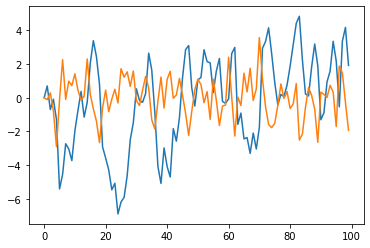

In [53]:
# Get data name
T, n = 100, 2

W = np.array([[0.95, -0.25], [1.0, 0.0]])
X = h.generate_var_2(T, n, W, np.identity(n))

# Load data
# data_name = "X_s4_n3_T100_random_matrix_2"
# W, X, expl = h.load_data(data_name)
# print(expl)

# Plot data
plt.plot(X)

# Show true matrix W
print(np.round(W, 2))

# Useful variables
T, n = np.shape(X)

In [54]:
def lasso_lars_W(X, alpha):
    """Performs LASSO with Lars on X with regularization value alpha"""
    
    # get regressor and variables
    y = X[1:]
    x = X[:-1]

    # initialize W_hat
    W_hat = np.array([])

    # Get our regularization method
    reg = LassoLars(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(n):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    # return W_hat after reshape
    return W_hat.reshape((n, n)).T

In [55]:
def lingnam_lasso_lars(X, step_size = 0.1):
    """Incrementally increase penalty by step_size until we have aa DAG"""
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # while we do not have a dag
    while not h.is_dag(W_hat):
        # increase alpha and do lasso with increased alpha
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)

    # return W_hat and print smallest alpha
    print(f"Smallest alpha for DAG: {round(alpha, 5)}.")
    return W_hat

In [56]:
# Perform Lingnam LASSO on Data
# Get smallest lambda for which G(W) is a DAG
# Return this DAG
print(lasso_lars_W(X, 1.0))

[[ 0.71167842 -0.12393953]
 [ 0.2023751   0.        ]]


In [57]:
def get_evolution_lasso(X, step_size = 0.2):
    """Returns the evolution paths for lasso with X as data"""
    
    # solution paths will be saved here
    results, alphas, coefs_zero = [], [], []
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # get number of non-zero coefficients for this value
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append the values of this iteration
    coefs_zero.append(non_zero_coefs)
    results.append(W_hat.flatten())
    alphas.append(alpha)
    
    # for simplicity I assume we have no DAG for OLS
    # else this approach is not meaningful anyway
    dag_yet, dag_alpha = False, 0
    
    # while we have non-zero coefficients
    while len(W_hat[W_hat != 0]) > 0:
        
        # perform lasso with increased step size
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)
        
        # get new nonzero coefficients
        non_zero_coefs = W_hat.copy().flatten()
        non_zero_coefs[non_zero_coefs != 0] = 1
        
        # check if we have found smallest lambda that makes a DAG        
        if h.is_dag(W_hat) and not dag_yet:
            dag_alpha = alpha
            dag_yet = True
        
        # append results
        results.append(W_hat.flatten())
        coefs_zero.append(non_zero_coefs)    
        alphas.append(alpha)
    
    # for nicer plot, last part of all zero plotted
    alpha *= 1.2
    W_hat = lasso_lars_W(X, alpha)
    
    # number of non-zero coefficents should be all
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append last results
    results.append(W_hat.flatten())
    coefs_zero.append(non_zero_coefs)
    alphas.append(alpha)
        
    # return results
    return results, alphas, coefs_zero, dag_alpha

In [58]:
# get results
results, alphas, coefs_zero, dag_alpha = get_evolution_lasso(X, step_size = 0.01)

# get points for which each coefficient is zero
zero_points = []

for i in range(len(coefs_zero[0])):
    zero_points.append(alphas[np.argmin(np.array(coefs_zero)[:,i])])

# get order of coefficients based on "strength"
order = np.argsort(zero_points)

# convert to numpy array for column accessibility
results = np.array(results)

# remove this, as we have a special color for this one
zero_points.remove(dag_alpha)

print(np.shape(results))
print(len(results[0]))

(606, 4)
4


In [60]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 12
})

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


Smallest alpha for DAG: 1.206.
Estimated W at blue vertical line:
[[ 0.65 -0.1 ]
 [ 0.    0.  ]].

True W:
[[ 0.95 -0.25]
 [ 1.    0.  ]].


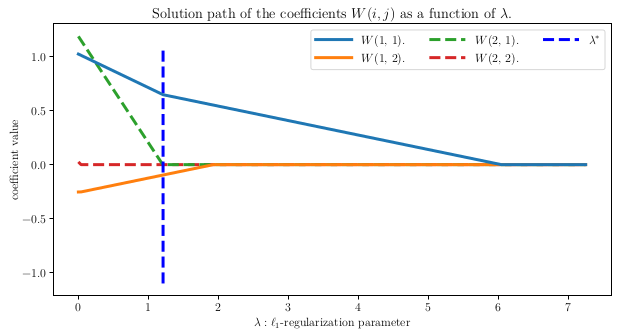

In [61]:
# Figure with title and labels
plt.figure(figsize=(10, 5))
plt.title(r"Solution path of the coefficients $W(i, j)$ as a function of $\lambda$.")
plt.xlabel(r'$\lambda: \ell_1$-regularization parameter')
plt.ylabel('coefficient value')
labels = [f"$W${(i + 1, j + 1)}." for i in range(n) for j in range(n)]
linestyles = ['-', '--', '-.']

# Plot solution paths
for i in range(len(results[0])):
    plt.plot(alphas, results[:, i], linewidth = 3.0, zorder = np.where(order == i)[0], label = labels[i], linestyle = linestyles[i // n])

# Plot lambda for which coefficients fade away
# plt.vlines(zero_points, -(np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), (np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), linestyle='--', linewidth = 1.5)

# Lambda for which G(W) is a dag is green and thicker
plt.vlines(dag_alpha, -(np.max(np.abs(W)) + 0.1), (np.max(np.abs(W)) + 0.1), linestyle = '--', colors = ['blue'], linewidth = 3, label = r'$\lambda^*$')

# Plot with legend
plt.legend(loc=1, handlelength = 3, ncol = n + 1)
plt.savefig('LASSOpath.pgf')
plt.show()

# Print estimated W and true W
print(f"Estimated W at blue vertical line:\n{np.round(lingnam_lasso_lars(X, 0.001), 2)}.\n")
print(f"True W:\n{W}.")
plt.savefig('figure LASSO 2.pgf')

In [63]:
h.save_data(X, W, "LASSO_example_2D", "time series used in the LASSO example with two variables.")

Dataset saved with name X_s3_n100_T2_LASSO_example_2D_1.
